In [2]:
from shapely.geometry import Polygon, LineString, Point
from shapely import affinity
import matplotlib.pyplot as plt
import math
import numpy as np

In [3]:
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return (ang2 - ang1) % (2 * np.pi)

In [60]:
def scale_fit(line, polygon, scalar):
    start = line.coords[0]
    end = line.coords[1]
    deltax = end[0] - start[0]
    deltay = end[1] - start[1]
    deltax = deltax * scalar
    deltay = deltay * scalar
    new_coords = Point(deltax + start[0], deltay + start[1])
    new_line = LineString([start, new_coords])
    # return new_line.intersection(polygon)
    return LineString([start, new_line.intersection(polygon)])

In [5]:
def line_to_vec(line):
    print(line.coords)
    return np.array([line.coords[1][0] - line.coords[0][0], line.coords[1][1] - line.coords[0][1]])

In [61]:
# want polygon, point, n, step, and threshold
# find the maximum distance from the point to the polygon -> extrapolate_scalar
# first line is [1, 0] unit vector extrapolated to intersect
# iterator:
# start at step angle, find unit vector
# extrapolate using scalar, find intersection point with polygon
# using that point and the points of the start line, make polygon and find area
# if area within polygon/n +- threshold area, store polygon, update start line,
# start new polygon
def polygon_partition(shape, origin, n, step, threshold):
    target_area = shape.area / n
    print("Target area: "  + str(target_area))
    scalar = shape.hausdorff_distance(origin)

    starting_line = LineString([origin, Point(origin.x + 1, origin.y)])
    starting_line = scale_fit(starting_line, shape, scalar)
    vector_line = line_to_vec(starting_line)

    area = 1000
    angle = 0

    while (abs(area - target_area) > threshold):
        angle += step
        print(angle)

        new_line = LineString([origin, Point(origin.x + math.cos(angle), origin.y + math.sin(angle))])
        new_line = scale_fit(new_line, shape, scalar)

        points = []
        # Creates a list of the points on the shape that are in the angle
        for point in shape.exterior.coords:
            point_vec = line_to_vec(LineString([origin, point]))
            point_angle = angle_between(vector_line, point_vec)
            if (point_angle <= angle and point_angle >= 0):
                # print("Point: " + str(point) + ", Angle: " + str(point_angle))
                points.append(point)

        #Adds the end of the starting line, the end of the new line, and the origin to round out the polygon
        points.insert(0, starting_line.coords[1])
        points.insert(0, origin)
        points.append(new_line.coords[1])
        points.append(origin)
        sector = Polygon(points)

        # print("Sector area: " + str(sector.area))
        area = sector.area

    
    # TOOO: Iterate through, incrementing angle, finding new line intersecting polygon
    # Sector needs to include union of the lines and the polygon
    print("succeeded: " + str(sector.area))
    return sector

In [62]:
polygon1 = Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]])
point = Point(0.5, 0.5)

sector = polygon_partition(polygon1, point, 5, .1, 0.005)

plt.plot(*polygon1.exterior.xy)
plt.plot(*sector.exterior.coords.xy, color='black')

Target area: 0.2


TypeError: ignored

In [58]:
def polygon_partition_v2(shape, origin, n, step, threshold, init_angle):
    target_area = shape.area / n
    print("Target area: "  + str(target_area))
    scalar = shape.hausdorff_distance(origin)
    print("Reached scalar")
    starting_line = LineString([origin, Point(origin.x + np.cos(init_angle), origin.y + np.sin(init_angle))])
    print("reached starting line")
    print(starting_line)
    starting_line = scale_fit(starting_line, shape, scalar)
    print("reached scale")
    print(starting_line)
    vector_line = line_to_vec(starting_line)
    print("reached vector")

    area = 1000
    angle = init_angle

    sector = Polygon([[0, 0], [1, 0], [0, 0]])

    while (abs(area - target_area) > threshold):
        angle += step
        print(angle)

        new_line = LineString([origin, Point(origin.x + math.cos(angle), origin.y + math.sin(angle))])
        new_line = scale_fit(new_line, shape, scalar)

        points = []
        # Creates a list of the points on the shape that are in the angle
        for point in shape.exterior.coords:
            point_vec = line_to_vec(LineString([origin, point]))
            point_angle = angle_between(vector_line, point_vec)
            if (point_angle <= angle and point_angle >= 0):
                # print("Point: " + str(point) + ", Angle: " + str(point_angle))
                points.append(point)

        #Adds the end of the starting line, the end of the new line, and the origin to round out the polygon
        points.insert(0, starting_line.coords[1])
        points.insert(0, origin)
        points.append(new_line.coords[1])
        points.append(origin)
        sector = Polygon(points)

        # print("Sector area: " + str(sector.area))
        area = sector.area

    print("succeeded: " + str(sector.area))
    return sector
    # return shape

In [21]:
def polygon_partitioner(shape, origin, n, step, threshold):
    sectors = []
    reduced_shape = shape
    for i in range(n):
        new_sector = polygon_partition(reduced_shape, origin, n - i, step, threshold)
        reduced_shape = reduced_shape.difference(new_sector)
        sectors.append(new_sector)

    return sectors

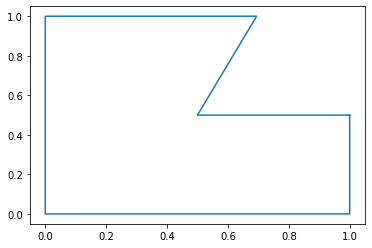

In [25]:
plt.plot(*polygon1.difference(sector).exterior.coords.xy)

# Working Code

In [68]:
def scale_fit_working(line, polygon, scalar):
    start = line.coords[0]
    end = line.coords[1]
    deltax = end[0] - start[0]
    deltay = end[1] - start[1]
    deltax = deltax * scalar
    deltay = deltay * scalar
    new_coords = Point(deltax + start[0], deltay + start[1])
    new_line = LineString([start, new_coords])
    return new_line.intersection(polygon)

In [69]:
def polygon_partition_working(shape, origin, n, step, threshold):
    target_area = shape.area / n
    print("Target area: "  + str(target_area))
    scalar = shape.hausdorff_distance(origin)

    starting_line = LineString([origin, Point(origin.x + 1, origin.y)])
    starting_line = scale_fit_working(starting_line, shape, scalar)
    vector_line = line_to_vec(starting_line)

    area = 1000
    angle = 0

    while (abs(area - target_area) > threshold):
        angle += step
        print(angle)

        new_line = LineString([origin, Point(origin.x + math.cos(angle), origin.y + math.sin(angle))])
        new_line = scale_fit_working(new_line, shape, scalar)

        points = []
        # Creates a list of the points on the shape that are in the angle
        for point in shape.exterior.coords:
            point_vec = line_to_vec(LineString([origin, point]))
            point_angle = angle_between(vector_line, point_vec)
            if (point_angle <= angle and point_angle >= 0):
                # print("Point: " + str(point) + ", Angle: " + str(point_angle))
                points.append(point)

        #Adds the end of the starting line, the end of the new line, and the origin to round out the polygon
        points.insert(0, starting_line.coords[1])
        points.insert(0, origin)
        points.append(new_line.coords[1])
        points.append(origin)
        sector = Polygon(points)

        # print("Sector area: " + str(sector.area))
        area = sector.area

    
    # TOOO: Iterate through, incrementing angle, finding new line intersecting polygon
    # Sector needs to include union of the lines and the polygon
    print("succeeded: " + str(sector.area))
    return sector

Target area: 0.2
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
0.9999999999999999
1.0999999999999999
1.2
succeeded: 0.20140255382897437


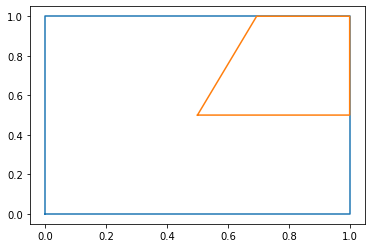

In [72]:
polygon_w = Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]])
point_w = Point([0.5, 0.5])

sector_w = polygon_partition_working(polygon_w, point_w, 5, .1, .005)

plt.plot(*polygon_w.exterior.coords.xy)
plt.plot(*sector_w.exterior.coords.xy)